# 3 Modeling

<img src="RhozyMap.png" width="400" />

######  Figure 5: Reduced metabolic pathway <a href="https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/7%20Fed-batch%20and%20continuous%20fermenters/Rhozytut_final.ipynb" target="_blank"> (Reynecke, 2018)</a>.

<img src="fluxmodel.PNG" width="720" height="200" />

###### Importing modules

In [1]:
# !pip install lmfit

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.integrate import odeint as integrate
import ipywidgets as widgets
# from IPython.display import display
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
from scipy.interpolate import interp1d
%matplotlib inline

###### Molecular formula

Microbial biomass has an approximate molecular formula of CH<sub>1.8</sub>O<sub>0.5</sub>N<sub>0.2</sub>, in g/cmol, <a href="https://biotechnologyforbiofuels.biomedcentral.com/track/pdf/10.1186/s13068-020-1664-8" target="_blank">(Swart et al, 2020)</a>. The molar mass of the metabolites, glucose and biomass are given in g/cmols below.

In [3]:
c, h, o, n = 12, 1, 16, 14      # g/cmol
MMs = c + 2*h + o               # glucose
MMx = c + 1.8*h + 0.5*o + 0.2*n # Biomass (R. oryzae)
MMe = c + 3*h + 0.5*o           # ethanol
MMn = c + 4*h + 2*n + o         # urea
MMf = c + h + o                 # fumaric acid
MMm = c + 1.5*h + 1.25*o        # Malic acid
MMco2 = c + 2*o                 # Carbon dioxide
MMe,MMx,MMs,MMn,MMf, MMm, MMco2 

(23.0, 24.6, 30, 60, 29, 33.5, 44)

In [4]:
def ferm_eq(C,t,var):
    Cx, Cs, Cf, Ce, Cm = C[0],C[1], C[2], C[3], C[4]
    t = t

    r = response_fun([Cx, Cs, Cf, Ce, Cm],t,var)     

    return [r[0]*Cx,  #X
            r[1]*Cx,  #S
            r[2]*Cx,  #F
            r[3]*Cx,  #E
            r[4]*Cx]  #M# NB: do not be confuse by the index number (nitrogen analysis has been skipped)

###### Interpolation

In [5]:
"""Interpolating function"""

def INTERP(Time_data,Time_model,Conc_model):
    Conc  = []
    model = interp1d(Time_model,Conc_model)
    for t in Time_data:
        Y = model(t)
        Conc.append(Y)

    Conc = np.array(Conc)
    return Conc

## 3.3 SMH 20% v/v (production phase)

###### Define cellular parameters

In [6]:
'''  parameters will be fit by lmfit  '''

params = Parameters()                           #Parameters
params.add('μ_max',value=0.1, min=0.001, max=4) #1#Growth rate of biomass
params.add('θ_max',value=0.1, min=0.001, max=4) #2#Maintenance rate requirements of the cell
params.add('β',value=0.1, min=0.001, max=20)     #3#Yield of biomass NADH******
params.add('γ',value=2.5, min=0, max=3)      #4#Energy required to make more cells******
params.add('P_O',value=1.25, min=0.01, max=3)   #5#Phosphate (added to ADP to form ATP) per atomic oxygen*****
params.add('α',value=0.1, min=0.1, max=0.11)    #6#Yield of biomass CO2******

In [7]:
# '''  parameters will be fit by lmfit  '''

# params = Parameters()                           #Parameters
# params.add('μ_max',value=0.1, min=0.001, max=4) #1#Growth rate of biomass
# params.add('θ_max',value=0.1, min=0.001, max=4) #2#Maintenance rate requirements of the cell
# params.add('β',value=0.1, min=0.001, max=4)     #3#Yield of biomass NADH
# params.add('γ',value=2.5, min=1.8, max=3)       #4#Energy required to make more cells
# params.add('P_O',value=1.25, min=1, max=3)      #5#Phosphate (added to ADP to form ATP) per atomic oxygen
# params.add('α',value=0.1, min=0.001, max=4)     #6#Yield of biomass CO2

In [8]:
# (<Parameter 'μ_max', value=0.005068721116674157 +/- 0.0022, bounds=[0.001:4]>,
#  <Parameter 'θ_max', value=0.018297133525909736 +/- 177, bounds=[0.001:4]>,
#  <Parameter 'β', value=3.994959584564099 +/- 1.33e+05, bounds=[0.001:4]>,
#  <Parameter 'γ', value=1.803303997683038 +/- 5.85e+04, bounds=[1.8:3]>,
#  <Parameter 'P_O', value=1.0000000027070315 +/- 1.13, bounds=[1:3]>,
#  <Parameter 'α', value=0.0010036788884418986 +/- 2.22e+04, bounds=[0.001:4]>)

###### Define cellular responce

In [9]:
def response_fun(C,t,var):
    Cx, Cs, Cf, Ce, Cm = C
    μ_max, θ_max, β, γ, P_O, α = var
    t = t
    r_gluc    = (Cs/Cx)*(1/tmax)       # ( Cs/[(Cx/L)*t] )
    
    if Cs <= 0:
        return [0,0,0,0,0]

    else:    
        μ = μ_max
        θ = θ_max
        A1 = np.matrix([[-1, 1+α, 1, 0, 0, 0, 0],
                      [0, 0, -1, 1, 1, 1, 0],
                      [0, -γ, 1/3, -1, 0, 1/3, 2*P_O],
                      [0, β, 1/3, -1/4, -1/2, 2, -2],
                      [1, 0, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 0, 0]])


        B1 = np.matrix([[0, 0, θ, 0, r_gluc, μ, (Yse*r_gluc)]]).T

        r1 = np.linalg.solve(A1,B1)

        return[r1[1,0],        #X
              -r1[0,0],        #S
               r1[3,0],        #F
               r1[4,0],        #E
               Ysm*(r1[0,0])]  #M# check wether you have t include the negative or not

###### Experimental data

In [10]:
data      = pd.read_csv('SMH.csv')
t0         = np.array(data['t'].T)
Csugar    = np.array(data['Cs'])
Cfumarate = np.array(data['Cf'])
Cethanol  = np.array(data['Ce'])
Cmalic    = np.array(data['Cm'])

 ###### Define fermentor parameters

In [11]:
'intitial conditions'
lg   = 0.05          #l# Total Volume of the growth phase (50ml)
lg_p = 0.01          #l# Volume of the growth phase(10ml) into 30ml_production 
Lp   = 0.04          #l# Total Volume of the production phase [30ml_production + 10ml of Lg]
gxo  = 0.45          #g# mass of biomass by 20%SMH assuming its the same for all N types 

Cso  = 100/MMs
Cxo  = gxo/(Lp*MMx)
Cno  = 0
Cfo  = 0
Ceo  = 0
Cmo  = 0
Co   = [Cxo, Cso, Cfo, Ceo, Cmo] #cmol/L# [Cxo, Cso, Cfo, Ceo,Cmo] in 

'Yields'
Ysm = (Cmalic[-1]/Cso)    #Cmolm/Cmols# yield fix for malic
Yse = (Cethanol[-1]/Cso)    #Cmolm/Cmols# yield fix for malic
# Ysf = (Cfumarate[-1]/Cso) #Cmolf/Cmols# yield fix for fumaric
'timespan'
tmin = 0                                # startup time
tmax = 144                              # termination time
tres = tmax
tspan=np.linspace(0,tmax+1,tres)        # define the timespan of the integration

 ###### Fitting function

In [12]:
"""Fitting function"""
def Fit(params):
    
    '''
    This function is used to determine the error between experimental data and that of the model.
    '''
    
    μ_max = params['μ_max']
    θ_max = params['θ_max']
    β     = params['β']
    γ     = params['γ']
    P_O   = params['P_O']
    α     = params['α']

    var = μ_max, θ_max,β, γ, P_O, α    
    Ci  = integrate(response_fun, Co, tspan, args = (var,))

    Cx = Ci[:, 0]
    Cs = Ci[:, 1]
    Cf = Ci[:, 2]
    Ce = Ci[:, 3]
    Cm = Ci[:, 4] # NB: do not be confuse by the index number (nitrogen analysis has been skipped)

    C1 = INTERP(t0,tspan,Cs) # sugar
    C2 = INTERP(t0,tspan,Cf) # fumarate
    C3 = INTERP(t0,tspan,Ce) # ethanol
    C4 = INTERP(t0,tspan,Cm) # malic


    Error_1 = (Csugar - C1)**1
    Error_2 = (Cfumarate - C2)**1
    Error_3 = (Cethanol - C3)**1
    Error_4 = (Cmalic - C4)**1

    return [Error_1,Error_2,Error_3,Error_4]

 ###### Plots

(<Parameter 'μ_max', value=0.004782816731081021, bounds=[0.001:4]>,
 <Parameter 'θ_max', value=0.0010000234595623542, bounds=[0.001:4]>,
 <Parameter 'β', value=19.952225140400866, bounds=[0.001:20]>,
 <Parameter 'γ', value=5.466868624459664e-10, bounds=[0:3]>,
 <Parameter 'P_O', value=0.046030295695168026, bounds=[0.01:3]>,
 <Parameter 'α', value=0.1, bounds=[0.1:0.11]>)

<Figure size 432x288 with 0 Axes>

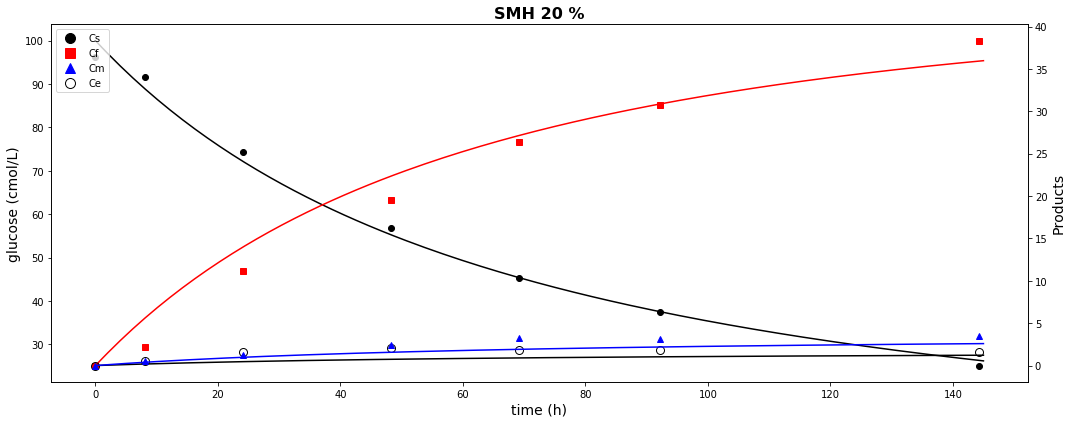

In [13]:
def Model(μ_max, θ_max, β, γ, P_O, α):    
    '''
    This function is used to plot the expermental data over the fitted model.
    '''
    
    var = μ_max, θ_max, β, γ, P_O, α 
    Ci  = integrate(response_fun, Co, tspan, args = (var,))

    Cx = Ci[:, 0]
    Cs = Ci[:, 1]
    Cf = Ci[:, 2]
    Ce = Ci[:, 3]
    Cm = Ci[:, 4] # NB: do not be confuse by the index number (nitrogen analysis has been skipped)

    plt.figure(1)
    fig, ax1 = plt.subplots(1, figsize=(15,6))
    
    ax1.set_title('SMH 20 %', fontsize=16, fontweight='bold')
    ax1.set_xlabel('time (h)', fontsize=14)
    ax1.set_ylabel('glucose (cmol/L)', color='black', fontsize=14)
    ax1.plot(tspan, Cs*MMs, color='black')
    ax1.plot([t0], [Csugar*MMs],linestyle='None', marker='o', color = 'black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Products', color='black', fontsize=14)  # we already handled the x-label with ax1
    ax2.plot(tspan, Cf*MMf, color='red')
    ax2.plot([t0], [Cfumarate*MMf], linestyle='None', marker='s', ms=6, color = 'red')
    ax2.plot(tspan, Ce*MMe, color='black')
    ax2.plot([t0], [Cethanol*MMe], linestyle='None', marker='o', ms=8, markerfacecolor="None", markeredgecolor='black')
    ax2.plot(tspan, Cm*MMm, color='blue')
    ax2.plot([t0], [Cmalic*MMm], linestyle='None', marker='^', ms=6, color='blue')
    ax2.tick_params(axis='y', labelcolor='black')
    
    #legend handling
    black_cirlcles   = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='Cs')
    red_square       = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=10, label='Cf')
    blue_triangle    = mlines.Line2D([], [], color='blue', marker='^', linestyle='None', markersize=10, label='Cm')
    black_cirlcles_w = mlines.Line2D([], [], color='black', marker='o', markerfacecolor="None", markeredgecolor='black',
                       linestyle='None', markersize=10, label='Ce')
    plt.legend(handles=[black_cirlcles, red_square, blue_triangle,black_cirlcles_w ])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

"""Fitting the parameters to the data"""

minner = Minimizer(Fit, params,nan_policy='omit') 
result = minner.minimize()

μ_max = result.params['μ_max']
θ_max = result.params['θ_max']
β     = result.params['β']
γ     = result.params['γ']
P_O   = result.params['P_O']
α   = result.params['α']

Model(μ_max, θ_max, β, γ, P_O, α)
μ_max, θ_max, β, γ, P_O, α   

1. Check the expected β,γ,P_O, and α values

2. Change:
 - fumarate spec
   - α 
     - constant (α = 0.1): Fumarate (below experimental points) and ethanol(above experimental points) do not have good     approximates.
     - changes (parameter): The profiles do not change (insignificant change, ethanol max decreases a bit ) and fumarate and      ethanol do not have good approximation. 
 - ethanol spec
   - α 
     - constant (α = 0.1): the ethanol fit is improved but fumarate (above experimental points) is still bad.  
     - changes (parameter): not much of change, i.e same as constant.
   - α and other parameters
     - constant α (0.1) and change in bounds (max and or min) of others: both fumarate and ethanol fit improved.
     - changes in α and change in bounds (max and or min) of others: nore or less the same as when α is constant.
       - velidate this observation and others using R<sup>2</sup> by comparison.
 - Conclusion:
 - Use the "constant α (0.1) and change in bounds (max and or min) of others" because the α is constant for other nitrogen sources.
 - And maybe change the bounds of the other nitrogen sources since smh is changed.
3. investigate why rate of glucose is constant (why it does not play around with the change in t, fix this for initial      t since we get an error there)

4. Proof:
 - have pictures of the graphs 
 - Not sure about the code

5. Conclusion:
 - when the minimum bound of the The P_O value is decreased, the Fitted value decreases as suspected.
 
6. Explain observations using:
 - Rate graphs
   - Net Carbon dioxide
     - Carbon dioxide to fumarate
     - Fumarate
     - Respiration
     - ethanol
     - and maybe oxygen
7. Next goal:
 - Investigate expected value of parameters for bounds to  check if they make sense
 - Check if I could maybe play around the energy (3θ) needed to excrete fumarate  to see if this changes with different nitrogen sources. That is,make it a parameter.
   - Check literature for the suggested 3θ.
   - I there is a case of 3θ changing with changes in nitrogen sources, we can include this in the results and discussion.
8. Questions:
 - Why is the ethanol lower in SMH?
   - Compare the respiration rates of nitrogen sources and see if they are equal.
     - Equal. Maybe its beacuse there is better aeration in SMH.
       - So, then you check the oxygen rates to check if aeration is an issue y looking at the rates.
       - Better aeration higher O<sub>2</sub> rates
     - Not equal. Maybe its because of the nitrogen source.
     - So, SMH as nitrogen source increases (improves) the rate of respiration.